# RespiCoV sequencing analysis by primer

Analyze fastq file(s) from nanopore sequencing output using [RespiCoV](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0264855) primers. Designed for ligation sequencting chemistry.

Run here on my sequencing run "Q8" which has a lot of reads. 

**Goals:**
 * Identify likely target matches per input sample, for downstream sequence alignment
 * Quantify PCR effectiveness and visualize the ways in which PCR mis-priming occurs in practice.
 * Run quickly on a single machine and scale linearly with input sequence
 * Enable iterative exploration of the data (cache the most expensive operations)
 
**Non-goals / future work elsewhere:**
 * Virus type-analysis for matches
 * Integrate Kraken / minimap2 analysis to suggest likely source of mis-priming. In particular, human matches
 * Map to human genome to study off-target mispriming in practice
 * Map reads to target genome sequences
 * Attempt to separate reads from distinct genomes pooled into the same barcode (eg. by type)
 * Use reads which only include one (or even zero) primers, eg. for tagmentation chemistry

## Initialization and configuration

In [38]:
from Bio.Seq import Seq
from Bio import SeqIO
from Bio import Align
import matplotlib_inline.backend_inline
import os
import pandas as pd
import RCUtils
import random

%load_ext autoreload
%autoreload 1
%aimport RCUtils

# Get high-dpi output for retina displays
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Be deterministic
random.seed(42)

fastQBaseDir = "../Q8/reads-sup/"

# Process only the samples with full or partial RespiCoV primers
barcodesToProcess = ["12", "13", "14", "15", "16", "17", "19", "20", "21"]

pd.options.display.max_rows = 50
pd.options.display.min_rows = 25

primers = RCUtils.readPrimers("RespiCovPrimers.fasta")
print("Read %i primers" % (len(primers)))

fastQPaths = [fastQBaseDir + "Q8-sup_barcode" + barcode + ".fastq" for barcode in barcodesToProcess]

# Compute and save primer matches if needed
for fastQPath in fastQPaths:
    RCUtils.generateSingleHitsFile(primers, fastQPath, limit=10_000)

def getAllPrimerMatches():
    for fastQPath in fastQPaths:
        for (read, hits) in RCUtils.getPrimerMatches(primers, fastQPath):
            barcode = fastQPath.split("_")[1].split(".")[0]
            yield (barcode,read,hits)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Read 115 primers
Found  Q8-sup_barcode12-hits.json
Found  Q8-sup_barcode13-hits.json
Found  Q8-sup_barcode14-hits.json
Found  Q8-sup_barcode15-hits.json
Processing  Q8-sup_barcode16.fastq....................................................................................................  63.05s
Processing  Q8-sup_barcode17.fastq....................................................................................................  69.96s
Processing  Q8-sup_barcode19.fastq....................................................................................................  78.18s
Processing  Q8-sup_barcode20.fastq....................................................................................................  65.31s
Processing  Q8-sup_barcode21.fastq....................................................................................................  59.30s


## How many primers are found in each read?
Notable here is that, in my first experiment nearly every read included at least one primer, suggesting PCR products did dominate the results. 
Proper amplification and sequencing should typically result in 2 primers per read, which is indeed the most common result. But it's also very common to have only a single primer.
It's also not unusual to have several primers, suggesting primer-dimers.

In [16]:
from collections import Counter

readsPerPrimerCount = Counter()
readTotal = 0
for (barcode, read, hits) in getAllPrimerMatches():
    readTotal += 1
    readsPerPrimerCount[len(hits)] += 1
print("%i total reads" % readTotal)

table = pd.DataFrame.from_dict(readsPerPrimerCount, orient="index", columns=["Reads"])
table.index.name = "Primer Count"
table.sort_index(inplace=True)
table["%"] = table["Reads"].apply(lambda r: 100 * round(r / readTotal, ndigits=4))
table

9000 total reads


,Reads,%
Primer Count,,
0,1643,18.26
1,2294,25.49
2,3363,37.37
3,580,6.44
4,531,5.90
5,170,1.89
6,206,2.29
7,51,0.57
8,66,0.73


This is similar to my RC1 and RC2 runs but with a lot more larger numbers of primers

## What is the distribution of primer match scores
Most hits exactly match a primer, but small numbers of mismatches are not uncommon.
In earlier testing, match scores of around 60% and lower were extremely common, purely by chance.

11874 of 16927 (70%) of primer hits are a perfect match


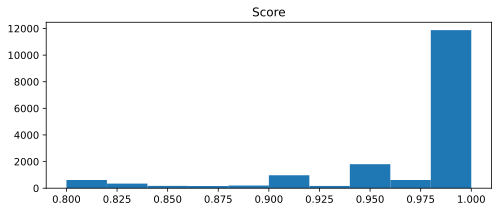

In [17]:
mrs = []
perfect = 0
for (subdir, record, hits) in getAllPrimerMatches():
    for hit in hits:
        mrs.append(hit.mr)
        if hit.mr == 1.0:
            perfect += 1

print("%d of %d (%d%%) of primer hits are a perfect match" % (perfect, len(mrs), 100*perfect/len(mrs)))
pd.DataFrame({'Score': mrs}).hist(figsize=(8,3), bins=10, grid=False);

This is better than previous (40%-50% perfect), likely because of using the Dorado sup basecaller this time.

## How often is each primer seen?
With a highly-specific PCR reaction I would expect to see the primer matches dominated by the legitimate target sequences. That's not the case here, suggesting perhaps the annealing temp was too low. More analysis is clearly needed in order to identify likely targets in the data.

,Fwd hits,Rev hits,%,Avg MR
Primer,,,,
Respirovirus 4,1012,514,9.02,0.97
Respirovirus 6,532,423,5.64,0.98
Human parechovirus 2,573,289,5.09,0.99
Respirovirus 8,394,380,4.57,0.99
Respirovirus 5,413,315,4.30,0.99
Rhinovirus/Enterovirus 1,315,226,3.20,0.94
Influenza A virus 7,312,194,2.99,0.99
Human parechovirus 1,335,169,2.98,0.99
Rhinovirus/Enterovirus 2,241,233,2.80,0.95


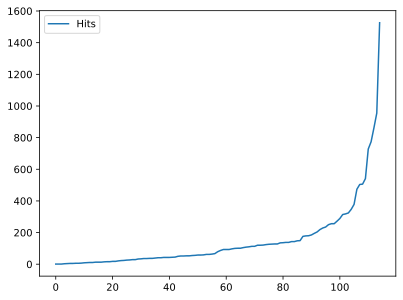

In [18]:
hitsPerPrimer = dict()
for p in primers:
    hitsPerPrimer[p.description] = [0,0,0]

hitsTotal = 0
for (subdir, record, hits) in getAllPrimerMatches():
    hitsTotal += len(hits)
    for hit in hits:
        hitsPerPrimer[hit.primer.description][1 if hit.rev else 0] += 1
        hitsPerPrimer[hit.primer.description][2] += hit.mr

def addPercent (entry):
    (primer, [fwd,rev,mrtot]) = entry
    return (primer, fwd, rev, round((fwd+rev) / hitsTotal * 100, ndigits=2), round(mrtot / (fwd+rev), ndigits=2))

allHits = sorted([f+r for (f, r, m) in hitsPerPrimer.values()])
pd.DataFrame(allHits, columns=["Hits"]).plot()

data = map(addPercent, filter(lambda p:p[1]!=[0,0,0], hitsPerPrimer.items()))
table = pd.DataFrame(data, columns=["Primer","Fwd hits", "Rev hits", "%", "Avg MR"])
table.set_index("Primer", inplace=True)
table.sort_values("%", ascending=False, inplace=True)
table

## Which primers are never seen exactly?
Given the high rate of off-target amplification in this experiment, if a primer is never seen at all, that may suggest a failure in the assay preparation
or synthesis. 

In [19]:
primerMaxMatch = dict.fromkeys(map(lambda p:p.description, primers), (0,0.0))

for (subdir, record, hits) in getAllPrimerMatches():
    for hit in hits:
        (count, maxMr) = primerMaxMatch[hit.primer.description]
        primerMaxMatch[hit.primer.description] = (count+1, max(maxMr, hit.mr))

table = pd.DataFrame.from_dict(primerMaxMatch, orient="index", columns=["Hits", "Max Match"])
table.index.name = "Primer"
table.sort_values("Max Match", ascending=False, inplace=True)
table[table["Max Match"] < 1.0]

,Hits,Max Match
Primer,,
Influenza B virus 5,1,0.87
Influenza B virus 2,1,0.86
Random control,1,0.82


There's no hits to the random control primer.

The same weak Influenza and RSV hits from RC1 also show up here as weak or missing, further suggesting those primers could be missing from the primer pool. But there are additional missing primer hits here, so perhaps this just represents better priming.

## What's the distribution of read lengths per subdir
We should expect this to look similar to gel output minus some constant offset for the adapters/barcodes. Note that unlike the RC1 run, I kept the default min length of 200bp.

200 of 9000 (2%) reads are less than 200bp


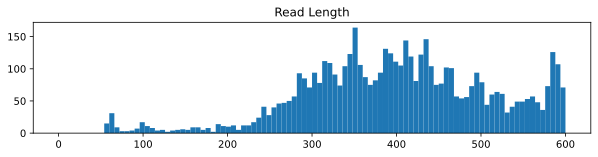

In [20]:
lessThan200 = 0
lengths=[]
for (subdir, read, hits) in getAllPrimerMatches():
    lengths.append(len(read.seq))
    if len(read.seq) < 200:
        lessThan200 += 1
pd.DataFrame({'Read Length': lengths}).hist(bins=100, figsize=(10,2), grid=False, range=(0,600));
print ("%d of %d (%d%%) reads are less than 200bp" % (lessThan200, len(lengths), 100*lessThan200/len(lengths)))

for fastQDir in RCUtils.getAllFastQDirs(fastQBaseDir):
    lengths=[]
    for (read, hits) in RCUtils.getPrimerMatches(primers, fastQDir):
        lengths.append(len(read.seq))
    subdir=os.path.basename(fastQDir)
    pd.DataFrame({subdir: lengths}).hist(bins=100, figsize=(10,2), grid=False, log=False, range=(0,600));    

Reads are relatively evenly distributed by barcode. 

## What's the distribution of primer positions?

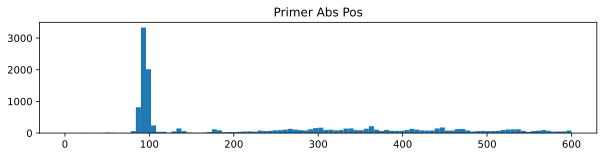

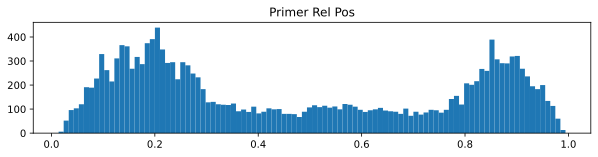

In [21]:
paPos=[]
prPos=[]

for (subdir, read, hits) in getAllPrimerMatches():
    paPos += map(lambda hit: hit.end, hits)
    prPos += map(lambda hit: (hit.start+hit.end)/2/len(read.seq), hits)

pd.DataFrame({'Primer Abs Pos': paPos}).hist(bins=100, figsize=(10,2), grid=False, range=(0,600))
pd.DataFrame({'Primer Rel Pos': prPos}).hist(bins=100, figsize=(10,2), grid=False);

The bimodal relative position may be because the most common pattern is a barcode prefix, primer, match region of arbitrary (but often low) length, primer and barcode suffix. 

## What is the distance between primer hits?
Can we tell the difference between primer-dimers and off-target amplification?

Human respiratory syncytial virus 1.0
target          762 TCCTGCATTGTCACAGTACCA 783
                  0 |||||||||||||||||||||  21
query             0 TCCTGCATTGTCACAGTACCA  21

Rhinovirus/Enterovirus 1
target          783 CAAGCACTTCTGTTTCCCCG 803
                  0 ||||||||||||||||||||  20
query             0 CAAGCACTTCTGTTTCCCCG  20

25% < 20bp
24% <= 0bp


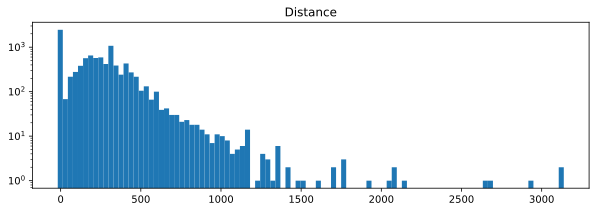

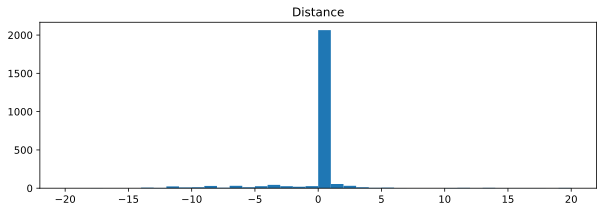

In [22]:
import matplotlib.pyplot as plt 

# Find the hits with the maximum overlap (below our threshold)
dists = []
countShort = 0
countAdjacent = 0
countTotal = 0
adjhit = None
for (subdir, read, hits) in getAllPrimerMatches():
    for i in range(len(hits)-1):
        countTotal += 1
        dist = hits[i+1].start - hits[i].end
        if dist < 20:
            countShort += 1
        if dist <= 0:
            countAdjacent += 1
        dists.append(dist)
        if dist == 0 and adjhit == None:
            adjhit = (read, hits[i], hits[i+1])

aligner = Align.PairwiseAligner(mode='local', match_score=1, mismatch_score=0, gap_score=-1)
print(adjhit[1].primer.description)
print(aligner.align(adjhit[0].seq, adjhit[1].primer.rcSeq if adjhit[1].rev else adjhit[1].primer.seq)[0])
print(adjhit[2].primer.description)
print(aligner.align(adjhit[0].seq, adjhit[2].primer.rcSeq if adjhit[2].rev else adjhit[2].primer.seq)[0])

print("%d%% < 20bp" % int(100*countShort/countTotal))
print("%d%% <= 0bp" % int(100*countAdjacent/countTotal))

df = pd.DataFrame({'Distance': dists})
df.hist(bins=100, grid=False, log=True, figsize=(10,3))
df.hist(bins=40, grid=False, range=(-20,20), figsize=(10,3));

Primer dimers are still very common in this run, but by ignoring reads shorter than 200bp we've filtered out more of them.

## How much do primer hits overlap below our threshold?
Partial overlap of primer hits is an indication of primer-dimers, which we should expect to be more common at lower overlap ratios. High or total overlapping primer hits would come from primers targetting different variants of the same locus, but we filter out such overlaps early. Look for any evidence that we haven't filtered out enough.

Max overlap score: 0.78, read 757320db-3d28-4687-bb1e-727735d36d09, len 877, suffix 46
Respirovirus 6 mr=1.00
target           70 TCATCATTACCAAATGCCCATGT 93
                  0 ||||||||||||||||||||||| 23
query             0 TCATCATTACCAAATGCCCATGT 23

Respirovirus 5 (rev) mr=1.00
target          421 ATGGCAAGGTCTACTGAACACA 443
                  0 ||||||||||||||||||||||  22
query             0 ATGGCAAGGTCTACTGAACACA  22

Respirovirus 1 mr=0.87
target          443 TCGACTTCTACAAATTTGTAGAA 466
                  0 |||||||||||||||||||...|  23
query             0 TCGACTTCTACAAATTTGTCCCA  23

Respirovirus 1 (rev) mr=0.87
target          448 TTCTACAAATTTGTAGAAGTCGA 471
                  0 |...|||||||||||||||||||  23
query             0 TGGGACAAATTTGTAGAAGTCGA  23

Respirovirus 5 mr=1.00
target          471 TGTGTTCAGTAGACCTTGCCAT 493
                  0 ||||||||||||||||||||||  22
query             0 TGTGTTCAGTAGACCTTGCCAT  22

Respirovirus 6 (rev) mr=1.00
target          808 ACATGGGCATTTGGTAATGAT

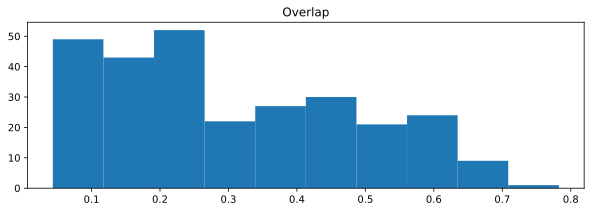

In [23]:
# Find the hits with the maximum overlap (below our threshold)
overlaps = []
maxo = 0
maxhit = None
for (subdir, read, hits) in getAllPrimerMatches():
    for i in range(len(hits)):
        for j in range(i):
            o = RCUtils.computeOverlap(hits[i],hits[j])
            if o > 0:
                overlaps.append(o)
                if o > maxo:
                    maxo = o
                    maxhit = (read, hits)

maxoend = max([h.end for h in maxhit[1]])
print("Max overlap score: %.2f, read %s, len %d, suffix %d" % 
      (maxo, maxhit[0].id, len(maxhit[0].seq), len(maxhit[0].seq) - maxoend))
for hit in sorted(maxhit[1], key=lambda h: h.start):
    print("%s%s mr=%.2f" % (hit.primer.description, " (rev)" if hit.rev else "", hit.mr))
    print(aligner.align(maxhit[0].seq, hit.primer.rcSeq if hit.rev else hit.primer.seq)[0])
      
pd.DataFrame({'Overlap': overlaps}).hist(figsize=(10,3), grid=False);

As expected, most overlap is by a small amount - just a few bases.
Looking at the read with the maximum overlap just below our 80% cutoff, it appears to be a quadruper primer-dimer combined with an off-target match. 

## What's the distribution of spans between possible primer pairs

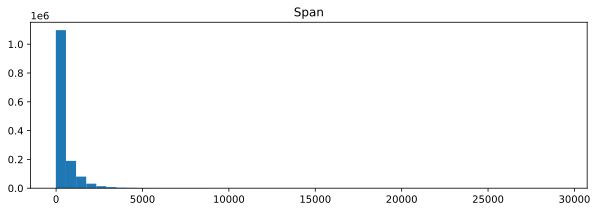

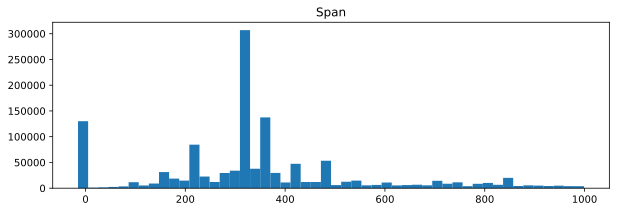

In [45]:
spans = []
for (subdir, read, hit1, hit2, span, pairname) in RCUtils.getPrimerPairs(primers, fastQPaths):
    spans.append(span)

df = pd.DataFrame({'Span': spans})
df.hist(bins=50, grid=False, figsize=(10,3));
df[df["Span"]<1000].hist(bins=50, grid=False, figsize=(10,3));

There's one obvious cluster around 350bp.

## Find the primer pairs that occur most often per subdir and analyze their spans
For any given primer pair we expect the (distance in the read from start of first primer to end of second) to be consistent from read to read in true matches, but possibly more variable for mispriming.  

In [44]:
from collections import defaultdict
import statistics

perSubdirPrimer = defaultdict(lambda:{"count":0, "spans":[], "mrs":[], "readIds":[]})
totalPairs = 0
likelyPairs = 0
goodPairs = 0

for (subdir, read, hit1, hit2, span, pairname) in RCUtils.getPrimerPairs(primers, fastQPaths):
    totalPairs += 1
    if (span > 50):
        # Simplify the pairname to remove the number after the final space
        pairname = pairname.rsplit(" ", 1)[0]
        row = perSubdirPrimer[(subdir, pairname)]
        row["spans"].append(span)
        row["mrs"].append(hit1.mr)
        row["mrs"].append(hit2.mr)
        row["readIds"].append(read.id)

known_good_subdir_pairs = set()
known_good_reads = set()
table = {"Subdir":[], "PrimerPair":[], "Count":[], "SpanMedian":[], "SpanSD":[], "MRMedian":[]}
for ((subdir, primerpair),row) in perSubdirPrimer.items():
    count = len(row["spans"])
    if count > 1:
        likelyPairs += count
        table["Subdir"].append(subdir)
        table["PrimerPair"].append(primerpair)
        table["Count"].append(count)
        spans = row["spans"]
        table["SpanMedian"].append(round(statistics.median(spans)))
        table["SpanSD"].append(round(statistics.pstdev(spans)))
        table["MRMedian"].append(round(statistics.median(row["mrs"]), ndigits=2))
    if count > 5:
        goodPairs += count
        known_good_subdir_pairs.add((subdir, primerpair))
        known_good_reads |= set(row["readIds"])

print("Showing %d of %d possible pairs (%d%%), with %d known good" % 
      (likelyPairs, totalPairs, int(100*likelyPairs/totalPairs), goodPairs))
df = pd.DataFrame(data=table)
df.set_index(["Subdir","PrimerPair"], inplace=True)
df.sort_values("Count", ascending=False, inplace=True)
pd.options.display.max_rows = 100
df.head(100)

Showing 1295753 of 1428646 possible pairs (90%), with 1295641 known good


Count  SpanMedian  \
Subdir                 PrimerPair                                              
Q8-sup_barcode13.fastq Respirovirus                       684871         414   
Q8-sup_barcode15.fastq SARS coronavirus 1/2               261763         322   
Q8-sup_barcode14.fastq Rhinovirus/Enterovirus             150265         351   
Q8-sup_barcode12.fastq Human metapneumovirus               47667         363   
                       Human parechovirus                  42980         294   
                       Rhinovirus/Enterovirus              27640         477   
Q8-sup_barcode19.fastq Respirovirus                        21990         414   
Q8-sup_barcode14.fastq Influenza A virus                   19382        1296   
Q8-sup_barcode17.fastq Influenza A virus                   12465         412   
Q8-sup_barcode15.fastq Rhinovirus/Enterovirus               3961         341   
                       Influenza A virus                    2978         335   
                       Respirovirus                         2580         327   
Q8-sup_barcode14.fastq Respirovirus                         2264         327   
Q8-sup_barcode13.fastq Rhinovirus/Enterovirus               1700         333   
Q8-sup_barcode14.fastq SARS coronavirus 1/2                 1519         322   
Q8-sup_barcode13.fastq Influenza A virus                    1179         333   
Q8-sup_barcode12.fastq Human respiratory syncytial virus     950         435   
Q8-sup_barcode13.fastq SARS coronavirus 1/2                  925         322   
Q8-sup_barcode12.fastq SARS coronavirus 1/2                  643         322   
                       Influenza A virus                     618         384   
Q8-sup_barcode20.fastq Human adenovirus                      592         333   
Q8-sup_barcode14.fastq Human adenovirus                      574         330   
Q8-sup_barcode15.fastq Human adenovirus                      571         330   
                       Human coronavirus OC43                530         275   
Q8-sup_barcode14.fastq Human coronavirus OC43                503         275   
Q8-sup_barcode16.fastq Human adenovirus                      477         330   
Q8-sup_barcode12.fastq Respirovirus                          432         327   
Q8-sup_barcode21.fastq Human adenovirus                      305         330   
Q8-sup_barcode16.fastq Influenza A virus                     251         349   
Q8-sup_barcode15.fastq Human metapneumovirus                 250         322   
Q8-sup_barcode13.fastq Human adenovirus                      248         329   
Q8-sup_barcode14.fastq Human metapneumovirus                 238         268   
Q8-sup_barcode20.fastq Influenza A virus                     211         431   
Q8-sup_barcode13.fastq Human coronavirus OC43                192         275   
Q8-sup_barcode21.fastq Influenza A virus                     187         339   
Q8-sup_barcode20.fastq SARS coronavirus 1/2                  150         336   
Q8-sup_barcode21.fastq SARS coronavirus 1/2                  127         322   
Q8-sup_barcode12.fastq Human adenovirus                      122         330   
Q8-sup_barcode13.fastq Human metapneumovirus                 121         401   
Q8-sup_barcode16.fastq SARS coronavirus 1/2                  111         322   
                       Rhinovirus/Enterovirus                100         350   
Q8-sup_barcode21.fastq Rhinovirus/Enterovirus                 81         339   
Q8-sup_barcode12.fastq Human coronavirus OC43                 74         275   
Q8-sup_barcode20.fastq Streptococcus pneumoniae               72         336   
Q8-sup_barcode21.fastq MERS coronavirus                       63         183   
Q8-sup_barcode16.fastq Respirovirus                           58         339   
Q8-sup_barcode20.fastq Epstein-Barr virus                     52         289   
Q8-sup_barcode15.fastq Human parechovirus                     41         472   
Q8-sup_barcode19.fastq SARS coronavirus 1/2                

* Respirovirus 1/2 is PIV1 (Respirovirus 1)
* Respirovirus 3/4 is PIV2 (actually orthorbulavirus 2)
* Respirovirus 5/6 is for PIV3 (Respirovirus 3)
* Respirovirus 7/8 is for PIV4a/b (actually a Rubulavirus)




## How do some of the good reads have more than 2 primer hits?

In [41]:
from collections import defaultdict
hitCounts = defaultdict(int)
printed = 0
for (subdir, read, hits) in getAllPrimerMatches():
    if (read.id in known_good_reads):
        if len(hits) > 2:
            print("%s read %s (len %d)" % (subdir, read.id, len(read.seq)))
            for hit in hits:
                print("   %.2f %i-%i: %s (%d%s)" % (hit.mr, hit.start, hit.end, hit.primer.description, len(hit.primer), " rev" if hit.rev else ""))
            printed += 1
            if printed > 10:
                break

barcode12 read 8c6f2b8c-9d89-4e49-a0b8-ac3ec32896e5 (len 453)
   1.00 75-96: Rhinovirus/Enterovirus 1 (21)
   0.95 263-283: Rhinovirus/Enterovirus 2 (21 rev)
   0.90 283-302: Rhinovirus/Enterovirus 2 (21)
barcode12 read f359829b-b4d1-4afe-9d62-74f8cfde2c24 (len 615)
   1.00 74-95: Human parechovirus 2 (21)
   1.00 243-263: Human metapneumovirus 1 (20 rev)
   1.00 263-284: Rhinovirus/Enterovirus 2 (21)
   1.00 545-564: Human parechovirus 1 (19 rev)
barcode12 read 706fccf7-cee0-40e2-9bc4-10e45689c47f (len 930)
   1.00 74-95: Human parechovirus 2 (21)
   0.90 379-398: Rhinovirus/Enterovirus 2 (21 rev)
   0.95 398-418: Rhinovirus/Enterovirus 2 (21)
   1.00 857-876: Human parechovirus 1 (19 rev)
barcode12 read 96ad4401-4c02-4a4c-a16c-6032e75fb3ab (len 872)
   1.00 73-92: Human parechovirus 1 (19)
   0.95 373-393: Human metapneumovirus 1 (20)
   0.95 535-555: Rhinovirus/Enterovirus 1 (21 rev)
   1.00 555-576: Human respiratory syncytial virus 1.0 (21)
   0.95 649-668: Human metapneumovirus 4

It's apparently quite common to have concatenated reads combining good target hits with off-target hits. It's also apparently common to have some primer-dimers attached to the primers from good reads.

## What's the cause of the high span deviation in barcode04?

In [13]:
table = {"Read":[], "Len":[], "Span":[]}
for (subdir, read, hit1, hit2, span, pairname) in RCUtils.getPrimerPairs(primers, fastQBaseDir, "barcode04"):
    if (pairname=="Rhinovirus/Enterovirus 1/3"):
        table["Read"].append(read.id)
        table["Len"].append(len(read))
        table["Span"].append(span)

df = pd.DataFrame(data=table)
df.set_index("Read", inplace=True)
df.sort_values("Span", inplace=True)
df

,Len,Span
Read,,
6e37d5be-28ec-4d77-ba09-37a5d8300663,957,335
bcafd0eb-5c18-4968-aec5-e6a7d6c65e6e,472,336
935e0457-2ef7-40bb-8ffa-9b088bf910a5,475,343
cae6b850-bf90-4494-8c9e-69d9dd4769d4,483,345
0569e872-7774-4477-83b3-33e7ac708bed,490,349
b32c490c-b445-45f1-9678-b4b5f1251eac,543,349
4124de8d-ea95-4782-88dc-c13b6b425785,487,349
3bb733b2-8ea6-4dd4-a7e2-ba87df3b3c1e,895,350
9a5fca45-003f-421e-92f4-4f55ccce7300,488,350


It looks like one read is a real outlier and others are shorter. Let's visualize this with an alignment

In [14]:
def hitString(hit):
    return "%s%s [%d,%d] (%.2f)" % (hit.primer.description, " (rev)" if hit.rev else "", hit.start, hit.end, hit.mr)

match1 = None
match2 = None
for (subdir, read, hit1, hit2, span, pairname) in RCUtils.getPrimerPairs(primers, fastQBaseDir, "barcode04"):
    if read.id=="5efec6dd-d30f-409b-a6d3-6fbec0ab345d":
        print(">" + hitString(hit1) + " - " + hitString(hit2))
        match1 = read[hit1.end:hit2.start]
    if read.id=="3bb733b2-8ea6-4dd4-a7e2-ba87df3b3c1e":
        longReadToStudy = read
        print(">" + hitString(hit1) + " - " + hitString(hit2))
        match2 = read[hit1.end:hit2.start]
print(aligner.align(match1.seq, match2.seq, "-")[0])

>Rhinovirus/Enterovirus 1 [67,89] (0.81) - Rhinovirus/Enterovirus 3 (rev) [443,464] (1.00)
>Rhinovirus/Enterovirus 3 [67,88] (1.00) - Rhinovirus/Enterovirus 1 (rev) [829,849] (0.90)
>Rhinovirus/Enterovirus 3 [457,478] (1.00) - Rhinovirus/Enterovirus 1 (rev) [829,849] (0.90)
target            1 ACCCTCGTATACGCTTCACCCGAGGCGAAAAATGAGGTTATCAATTTCCACCGAAATTGC
                  0 |...||||||||||||||||||||||||||||||||||||||.-||.||..|-|||.|||
query           349 AATTTCGTATACGCTTCACCCGAGGCGAAAAATGAGGTTATCG-TTACCCGC-AAAGTGC

target           61 CACCTGAGAAACCTAGTAGCATTTTTGAAGCCTATGGTTGGTCGCTCAACTGTTTGCAAC
                 60 |..|-||||||||||||||||||||||||||||||||||||||||||||||||||.|.-|
query           291 CTAC-GAGAAACCTAGTAGCATTTTTGAAGCCTATGGTTGGTCGCTCAACTGTTTACC-C

target          121 CCCAGTAGACCTGGCAGATGAGGCTAGATGTTCCCC-CTTGCTGATGAGTGATCTGGCCT
                120 ..||||||||||||||||||||||||||||||||||-|..||-||||-|||||||.||..
query           233 AGCAGTAGACCTGGCAGATGAGGCTAGATGTTCCCCACCAGC-GATG-GTGATCT

The long read matches well at the end, but what's the extra stuff at the start?

In [15]:
print(match2.seq)


TGGTTCCATCCATAGTTGCCCATTACGACTGCAGACATGTTGGATTACATGCAACAGCTACGGGGTTAGGATTAGCCACATTCAGGGGCGGAGGACTCAAAGTGAGCACAATAGACTCTTCACACCTTGTCCGCTTTCTGGCTTCACACTCAATAGAGTGTGCAGGCAACCACGCGAGCTAGATCACCATCGCTGGTGGGGAACATCTAGCCTCATCTGCCAGGTCTACTGCTGGGTAAACAGTTGAGCGACCAACCATAGGCTTCAAAAATGCTACTAGGTTTCTCGTAGGCACTTTGCGGGTAACGATAACCTCATTTTTCGCCTCGGGTGAAGCGTATACGAAATTTT


Ah, doing a blast search I see the same sequence is duplicated, so we have a concatemer of two hits. `computePrimerHits` returns at most one hit per primer with a TODO to find others.  Are there are other primer matches in this read?

In [16]:
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq, MutableSeq

ms = MutableSeq(longReadToStudy.seq)
hits = []
while True:
    newHits = RCUtils.computePrimerHits(SeqRecord(ms), primers, True)
    if len(newHits) == 0:
        break
    for hit in newHits:
        ms[hit.start:hit.end]="N" * (hit.end-hit.start)
    hits += newHits

for hit in hits:
    print("   %.2f %i-%i: %s (%d%s)" % (hit.mr, hit.start, hit.end, hit.primer.description, len(hit.primer), " rev" if hit.rev else ""))


   1.00 67-88: Rhinovirus/Enterovirus 3 (21)
   1.00 457-478: Rhinovirus/Enterovirus 3 (21)
   0.90 829-849: Rhinovirus/Enterovirus 1 (21 rev)


Interesting, there's no matching reverse primer for the first half.

# Summary
From everything we've computed above, generate summary stats for each subdir.

In [36]:
statsPerSubdir = defaultdict(lambda: defaultdict(int))
for (subdir, read, hits) in getAllPrimerMatches():
    stats = statsPerSubdir[subdir]
    stats["reads"] += 1
    stats["bases"] += len(read.seq)
    if len(hits) > 0:
        stats["withHits"] += 1

        # Calculate total bases covered by all hits
        hitBases = 0
        for hit in hits:
            hitBases += hit.end - hit.start

        if len(hits) > 1:
            stats["withMultipleHits"] += 1
            # Compute max distance between end of one hit and start of next
            maxSpan = 0
            for i in range(len(hits)-1):
                span = hits[i+1].start - hits[i].end
                if span < 0:
                    hitBases += span # Subtract overlap to avoid double-counting
                else:
                    stats["spanBases"] += span
                maxSpan = max(maxSpan, span)
            if maxSpan > 0:
                stats["withSpan"] += 1
                if maxSpan > 50:
                    stats["withSpanOver50"] += 1
        stats["hitBases"] += hitBases

    stats["knownGood"] += 1 if read.id in known_good_reads else 0

relStatsPerSubdir = defaultdict(dict)
for (subdir, stats) in statsPerSubdir.items():
    rs = relStatsPerSubdir[subdir]
    rs["reads"] = stats["reads"]
    rs["no hits"] = (stats["reads"] - stats["withHits"]) / stats["reads"]
    rs["lone hit"] = (stats["withHits"] - stats["withMultipleHits"]) / stats["reads"]
    rs["only dimers"] = (stats["withMultipleHits"] - stats["withSpan"]) / stats["reads"]
    rs["short span"] = (stats["withSpan"] - stats["withSpanOver50"]) / stats["reads"]
    rs["off target"] = (stats["withSpanOver50"] - stats["knownGood"]) / stats["reads"]
    rs["good"] = stats["knownGood"] / stats["reads"]
    rs["primer bases"] = stats["hitBases"] / stats["bases"]
    rs["span bases"] = stats["spanBases"] / stats["bases"]

with pd.option_context('float_format', '{:.1%}'.format):
    display(pd.DataFrame.from_dict(relStatsPerSubdir, orient='index'))

,reads,no hits,lone hit,only dimers,short span,off target,good,primer bases,span bases
barcode12,1000,8.4%,20.2%,0.0%,0.2%,39.4%,31.8%,7.9%,50.0%
barcode13,1000,8.6%,27.9%,0.3%,0.0%,6.1%,57.1%,6.8%,42.8%
barcode14,1000,52.3%,36.3%,0.1%,0.2%,5.4%,5.7%,1.2%,7.7%
barcode15,1000,72.9%,12.2%,0.5%,0.0%,1.0%,13.4%,1.0%,6.2%
barcode16,1000,3.0%,29.2%,1.2%,0.7%,63.5%,2.4%,8.5%,45.2%
barcode17,1000,3.3%,24.1%,0.2%,0.2%,18.2%,54.0%,7.6%,50.4%
barcode19,1000,6.4%,24.0%,0.4%,0.2%,1.7%,67.3%,7.7%,52.1%
barcode20,1000,5.1%,26.2%,0.8%,0.5%,65.0%,2.4%,7.7%,46.7%
barcode21,1000,4.3%,29.3%,0.5%,0.1%,64.6%,1.2%,8.2%,46.3%
